# DQN algorithm

- 目标: 训练一个策略，使得  the discounted cumulative reward 最大
- R_t0 = sum( gamma**(t-t0) * r_t)  # t0时刻的结果做大 
- 等价 Q(S1) = r1 + gamma\*Q(s2) =  r1 + gamma\*(r2 + gamma\*Q(s3)) = r1 + gamma\*r2 + gamma\*\*2r3


    - 理想: 已知函数 Q(State,Action) -> R, 已知当前状态, 求最大收益
    - 现实: 无法清楚了解 Q
    - 解决: 利用神经网络（是universal function approximators），创建并训练Q的近似函数

- Bellman equation : Q(s,a) = r + gamma\*Q(s’，pie(s')) 是一个近似方程
- delta = Q(s,a) - (r + gamma\*Q(s’，pie(s'))) 为误差
- 为尽量减小这个错误，使用 Huber 损失，当误差较小时，Huber 损失类似于均方误差MSE；而当误差较大时，表现为平均绝对误差MAE。当Q的估计值非常嘈杂时，Huber 对异常值的鲁棒性更强

In [1]:
def huber(delta_list):
    def delta_to_loss(delta):
        if abs(delta)<=1:
            return delta**2 / 2
        else :
            return abs(delta)-1/2
    loss_list = [delta_to_loss(delta) for delta in delta_list]
    return sum(loss_list)

# 环境导入

- Cartpole任务的设计为智能点输入代表环境状态(位置(上位/下位)、速度(方向/数值)等）的4个实际值

In [2]:
# !pip install Gym

In [3]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T  # 视觉处理工具

env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()  # 展示动态图或多个窗口
# ion()命令开启了交互模式，没有使用ioff()关闭的话，则图像会一闪而过，并不会常留

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 经验回放

- experience replay memory for training our DQN

- 存储智能体观察到的转换(transitions)，以后可以重用
- 对存储transitions进行随机抽样，可以稳定DQN训练过程

In [4]:
# 定义命名元组 Transition 为环境中的单个转换，将 状态(state,action）: 结果(next_state,reward）
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward')) 

# 循环缓冲区类别，保存最近观察到的转换，有点儿像dataset
class ReplayMemory(object):
    """ 缓存最近观察到的转换, 数据格式为 list 可以考虑使用 ndarray """

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """将 Transition 加入缓存区"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """缓存区中 抽取 Transition """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [29]:
transitions = [Transition([1,1],1,[1,2],0),Transition([1,1],1,[1,2],0),]

In [58]:
transitions

[Transition(state=[1, 1], action=1, next_state=[1, 2], reward=0),
 Transition(state=[1, 1], action=1, next_state=[1, 2], reward=0)]

In [72]:
batch = Transition(*tuple(zip(*transitions)))

In [74]:
batch.next_state

([1, 2], [1, 2])

# Q-Network
- 使用卷积神经网络
- 输入 当前画面与之前画面的差异
- 输出 g Q(s,left) and Q(s,right) # s 神经网络的差异为输入

In [5]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # 线性分类器的数量取决于 图片尺寸和卷积层的输出 
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # 单元素或批次计算下次action
    # Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

# 获取输入

- 用于从环境中提取和处理渲染图像

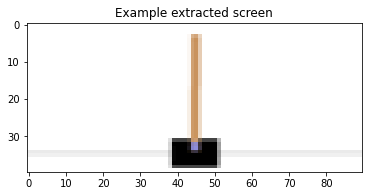

In [7]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

# 参数配置

In [7]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9  # probability of choosing a random action will start at
EPS_END = 0.05  # probability of choosing a random action will will decay exponentially towards
EPS_DECAY = 200  # 衰减的速率
TARGET_UPDATE = 10


# 获取屏幕大小，以便我们可以根据从 ai-gym 返回的形状正确初始化层。
# 这一点上的平常尺寸接近3x40x90，这是在get_screen(）中抑制和缩小的渲染缓冲区的结果。
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    """ 根据 epsilon-greedy策略选择一个行为 """
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    """绘制迭代次数持续时间，以及过去100迭代次数的平均值"""
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

# 训练方法

In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # 转置批样本(有关详细说明，请参阅https://stackoverflow.com/a/19343/3343043）。
    # This converts batch-array of Transitions to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # 计算非最终状态的mask掩码并连接批处理元素(最终状态将是模拟结束后的状态）
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # 计算 Q(s_t, a) - 模型计算 Q(s_t)，然后选择所采取action的列。
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 计算下一个状态的 V(s_{t+1})。
    # 非最终状态下一个状态的预期操作值是基于“旧”目标网络计算的；用 max(1)[0] 选择的最佳奖励。
    # 这是基于掩码合并的，这样当状态为最终状态时，我们将获得预期状态值或0。

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

# 训练主循环

In [13]:
num_episodes = 50
for i_episode in range(num_episodes):
    
    # 初始化环境与状态
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    
    for t in count():
        # 选择并执行 action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
            
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

In [1]:
import gym
env = gym.make('CartPole-v0')   # 定义使用 gym 库中的那一个环境

In [4]:
env.observation_space

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)

In [5]:
env.observation_space.high

array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)

In [5]:
import numpy as np

In [14]:
names = np.array(['Bob','Joe','Will','Bob','Will','Joe','Joe'])
 #正态分布随机数

In [15]:
mask = (names=='Bob')|(names=='Joe')

In [16]:
mask

array([ True,  True, False,  True, False,  True,  True])

In [22]:
data[names!='Joe'] = 7

In [23]:
data

array([[ 7,  7,  7,  7],
       [ 4,  5,  6,  7],
       [ 7,  7,  7,  7],
       [ 7,  7,  7,  7],
       [ 7,  7,  7,  7],
       [20, 21, 22, 23],
       [24, 25, 26, 27]])

In [13]:
torch.arange(0.1,0.4,0.1)#.max(1)# [1].view(1, 1)

tensor([0.1000, 0.2000, 0.3000, 0.4000])

In [17]:
a = np.array([[0.1,0.2,0.4,0.3],[0.1,0.2,0.4,0.3]])
b = torch.from_numpy(a)

In [24]:
b.max(1)[1]

tensor([2, 2])

In [76]:
?optim.RMSprop